# 02 - preprocesado

En este notebook vamos a realizar el preprocesado de los datos que obtenemos del `train.csv` de la competencia de Kaggle Udea/ai4eng 20252.

Este preprocesado es necesario con el fin de 'normalizar' los distintos datos que existen en el `train.csv` ya sea porque estan en un formato nulo o simplemente para facilitar la posterior creacion del modelo.

El objetivo final es crear una función de preprocesado flexible que nos permita probar distintas estrategias (imputación, escalado, codificación) fácilmente en la siguiente entrega.

### Realizamos importaciones iniciales y cargamos los datos

In [4]:
import pandas as pd
import numpy as np
import os, json
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import userdata
!pip install unidecode
from unidecode import unidecode

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.2 MB/s eta 0:00:00


In [5]:
user = userdata.get('KAGGLE_USERNAME')
key = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = user
os.environ["KAGGLE_KEY"] = key
assert user and key, "Faltan los secretos KAGGLE_USERNAME/KAGGLE_KEY"
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia
!unzip udea*.zip > /dev/null
!wc *.csv

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.32GB/s]
   296787    296787   4716673 submission_example.csv
   296787   4565553  59185238 test.csv
   692501  10666231 143732437 train.csv
  1286075  15528571 207634348 total


In [6]:
z = pd.read_csv("train.csv")
z.head(5)

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,...,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,...,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,...,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,...,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,...,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,...,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


## Limpieza inicial de datos duplicados y texto

Primero, revisamos la información básica y eliminamos columnas duplicadas.

In [7]:
z.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

In [9]:
if "F_TIENEINTERNET.1" in z.columns:
  z = z.drop(columns=["F_TIENEINTERNET.1"])

Ahora, limpiemos columnas de texto, de este modo unificamos categorias y evitamos duplicados.

In [11]:
def clean_text(text):
  if not isinstance(text, str):
    return text

  text = unidecode(text).upper() # Quitar tildes y pasar a mayúsculas

  # Correcciones manuales
  corrections = {
    'INGENIER?A': 'INGENIERIA',
    'ADMINISTRACI?N': 'ADMINISTRACION',
    'COMUNICACI?N': 'COMUNICACION',
    'DISE?O': 'DISENO',
    'QU?MICA': 'QUIMICA',
    'FILOSOF?A': 'FILOSOFIA',
    'ECONOM?A': 'ECONOMIA'
  }

  for wrong, right in corrections.items():
    text = text.replace(wrong, right)
  return text

# Aplicar limpieza a las columnas de texto relevantes que e identificado de momento
text_cols_to_clean = ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']

for col in text_cols_to_clean:
  if col in z.columns:
    z[col] = z[col].apply(clean_text)

print("Columnas de texto limpiadas.")
print("\nValores únicos de E_PRGM_ACADEMICO (ejemplo):")
print(z['E_PRGM_ACADEMICO'].value_counts().head(10))

Columnas de texto limpiadas.

Valores únicos de E_PRGM_ACADEMICO (ejemplo):
E_PRGM_ACADEMICO
ADMINISTRACION DE EMPRESAS            76750
DERECHO                               53244
CONTADURIA PUBLICA                    51846
PSICOLOGIA                            49309
INGENIERIA INDUSTRIAL                 34818
INGENIERIA CIVIL                      20943
MEDICINA                              18099
INGENIERIA DE SISTEMAS                18050
LICENCIATURA EN PEDAGOGIA INFANTIL    14773
INGENIERIA AMBIENTAL                  12990
Name: count, dtype: int64


## Limpieza y Codificacion para variable objetivo

Nuestra variable objetivo `RENDIMIENTO_GLOBAL` es categórica. Debemos asegurarnos de que solo contenga los valores válidos y luego codificarla numéricamente para el análisis de correlación y el entrenamiento.

In [12]:
print(f"Valores únicos antes de limpiar: {z['RENDIMIENTO_GLOBAL'].unique()}")

# Filtrar solo las categorías válidas
valid_categories = ['alto', 'medio-alto', 'medio-bajo', 'bajo']
z = z[z['RENDIMIENTO_GLOBAL'].isin(valid_categories)].copy()

print(f"\nValores únicos después de limpiar: {z['RENDIMIENTO_GLOBAL'].unique()}")

# Definir un mapeo ordinal para la variable objetivo
target_map = {
  'bajo': 0,
  'medio-bajo': 1,
  'medio-alto': 2,
  'alto': 3
}

# Crear la columna 'Y_NUMERIC' para el análisis
z['Y_NUMERIC'] = z['RENDIMIENTO_GLOBAL'].map(target_map)

Valores únicos antes de limpiar: ['medio-alto' 'bajo' 'alto' 'medio-bajo']

Valores únicos después de limpiar: ['medio-alto' 'bajo' 'alto' 'medio-bajo']


## Análisis de Correlación

Ahora que tenemos una variable objetivo numérica (`Y_NUMERIC`), podemos ver cómo se correlaciona con las otras variables numéricas del dataset.

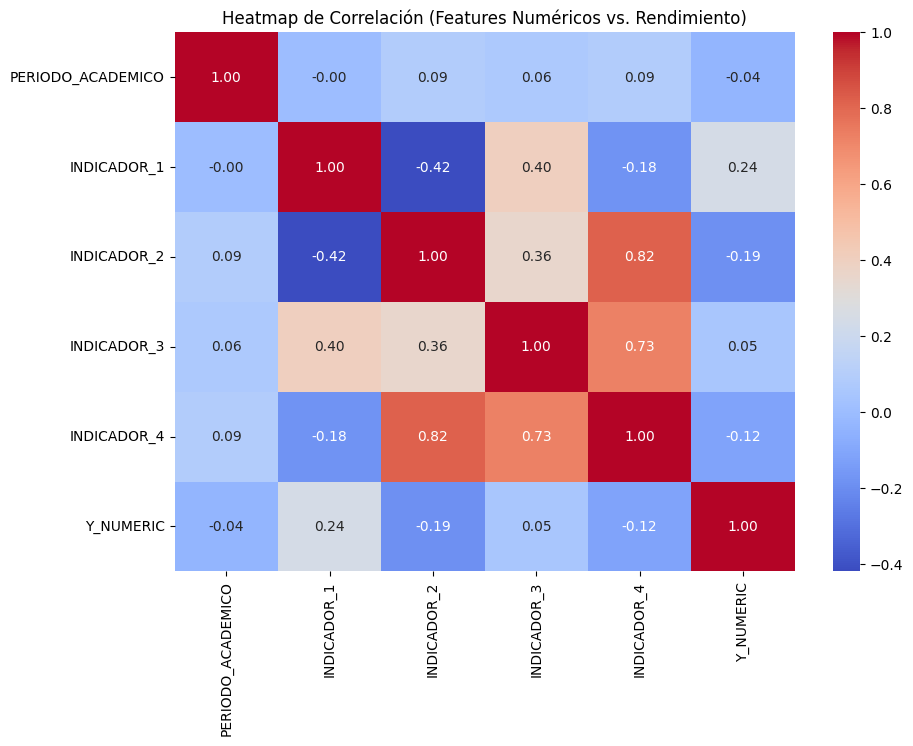

In [13]:
# Seleccionar columnas numéricas y la nueva variable objetivo
numerical_features = ['PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4', 'Y_NUMERIC']
corr_matrix = z[numerical_features].corr()

# Graficar el heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap de Correlación (Features Numéricos vs. Rendimiento)')
plt.show()



> Vemos una cierta corelacion entre el indicador 2 y el indicadir 4 siendo esta un 0.82


## Creacion de funcion

El eliminar ya sea columnas o filas con datos nulos podria hacernos perder una buena cantidad de informacion que al final termine impactando en el modelo.
Con esto como base podriamos pensar que una estrategia más completa o adecuada sea mediante el uso de `Pipeline` utilizando sus diversas estrategias como el de imputacion y el de escalado.

Organicemos los mapas para las variables categoricas

In [15]:
ordinal_maps = {
  'E_VALORMATRICULAUNIVERSIDAD': [
      'NO PAGO MATRICULA',
      'MENOS DE 500 MIL',
      'ENTRE 500 MIL Y MENOS DE 1 MILLON',
      'ENTRE 1 MILLON Y MENOS DE 2.5 MILLONES',
      'ENTRE 2.5 MILLONES Y MENOS DE 4 MILLONES',
      'ENTRE 4 MILLONES Y MENOS DE 5.5 MILLONES',
      'ENTRE 5.5 MILLONES Y MENOS DE 7 MILLONES',
      'MAS DE 7 MILLONES'
  ],
  'E_HORASSEMANATRABAJA': [
      '0',
      'MENOS DE 10 HORAS',
      'ENTRE 11 Y 20 HORAS',
      'ENTRE 21 Y 30 HORAS',
      'MAS DE 30 HORAS'
  ],
  'F_ESTRATOVIVIENDA': [
      'SIN ESTRATO', 'ESTRATO 1', 'ESTRATO 2', 'ESTRATO 3', 'ESTRATO 4', 'ESTRATO 5', 'ESTRATO 6'
  ],
  'F_EDUCACIONPADRE': [
      'NO SABE',
      'NINGUNO',
      'PRIMARIA INCOMPLETA',
      'PRIMARIA COMPLETA',
      'SECUNDARIA (BACHILLERATO) INCOMPLETA',
      'SECUNDARIA (BACHILLERATO) COMPLETA',
      'TECNICA O TECNOLOGICA INCOMPLETA',
      'TECNICA O TECNOLOGICA COMPLETA',
      'EDUCACION PROFESIONAL INCOMPLETA',
      'EDUCACION PROFESIONAL COMPLETA',
      'POSTGRADO'
    ],
    'F_EDUCACIONMADRE': [
      'NO SABE',
      'NINGUNO',
      'PRIMARIA INCOMPLETA',
      'PRIMARIA COMPLETA',
      'SECUNDARIA (BACHILLERATO) INCOMPLETA',
      'SECUNDARIA (BACHILLERATO) COMPLETA',
      'TECNICA O TECNOLOGICA INCOMPLETA',
      'TECNICA O TECNOLOGICA COMPLETA',
      'EDUCACION PROFESIONAL INCOMPLETA',
      'EDUCACION PROFESIONAL COMPLETA',
      'POSTGRADO'
  ]
}

# Función para seleccionar el escalador
def make_scaler(kind='standard'):
  if kind == 'standard': return StandardScaler()
  if kind == 'minmax': return MinMaxScaler()
  if kind == 'robust': return RobustScaler()
  return 'passthrough'

Contineomos ahora si con la función como tal, en esta la idea es que contenga toda la logica reunida del preprocesado, aceptando parametros para cambiar las estrategias de imputacion, codificación y escalado.

In [21]:
def build_preprocessor(
    df: pd.DataFrame,
    y_col: str = 'RENDIMIENTO_GLOBAL',
    id_col: str = 'ID',
    num_impute: str = 'median',
    cat_impute: str = 'most_frequent',
    encode_categorical: str = 'onehot',
    ordinal_maps: dict = {},
    scale_numeric: str = 'standard'
):
  data = df.copy() # Es importante copiar el df porque los df pueden tener como varios "nombres" o asi
  # lo entiendo yo, el caso es que si no se hace como una copia y se modifica 1 se ven afectado el original tambien

  y = data.pop(y_col) if y_col in data.columns else None

  cols_to_drop = [id_col, 'Y_NUMERIC']
  data = data.drop(columns=[col for col in cols_to_drop if col in data.columns])

  num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
  cat_cols = data.select_dtypes(include=['object']).columns.tolist()

  ordinal_cols = [col for col in cat_cols if col in ordinal_maps]
  onehot_cols = [col for col in cat_cols if col not in ordinal_maps]

  print(f"Columnas numéricas: {len(num_cols)}")
  print(f"Columnas categóricas (OneHot): {len(onehot_cols)}")
  print(f"Columnas categóricas (Ordinal): {len(ordinal_cols)}")

  num_pipe = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy=num_impute)),
      ('scaler', make_scaler(scale_numeric))
  ])

  onehot_pipe = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy=cat_impute)),
      ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
  ])

  ordinal_categories = [ordinal_maps[col] for col in ordinal_cols]

  if cat_impute == 'constant':
    imputer_strategy = SimpleImputer(strategy='constant', fill_value='DESCONOCIDO')
    ordinal_categories_with_unknown = [cats + ['DESCONOCIDO'] for cats in ordinal_categories]
    unknown_value_param = -1
    dtype_param = int
  else:
    imputer_strategy = SimpleImputer(strategy='most_frequent')
    ordinal_categories_with_unknown = ordinal_categories
    unknown_value_param = np.nan
    dtype_param = np.float64

  ordinal_pipe = Pipeline(steps=[
      ('imputer', imputer_strategy),
      ('encoder', OrdinalEncoder(
          categories=ordinal_categories_with_unknown,
          handle_unknown='use_encoded_value',
          unknown_value=unknown_value_param,
          dtype=dtype_param
      )),
      ('scaler', make_scaler(scale_numeric))
  ])

  preprocessor = ColumnTransformer(
      transformers=[
          ('num', num_pipe, num_cols),
          ('onehot', onehot_pipe, onehot_cols),
          ('ordinal', ordinal_pipe, ordinal_cols)
      ],
      remainder='drop',
      n_jobs=1
  )

  return preprocessor, data, y


## Aplicando funcion de preprocesado

In [25]:
# Definimos las columnas ID y Target
target_col = 'RENDIMIENTO_GLOBAL'
id_col = 'ID'

y = z[target_col].map(target_map)
X = z.drop(columns=[target_col, id_col, 'Y_NUMERIC']) # Quitamos Y, ID y la Y numérica


preproc, X_features, y_target = build_preprocessor(
    z,
    y_col=target_col,
    id_col=id_col,
    num_impute='median',
    cat_impute='most_frequent',
    scale_numeric='standard',
    ordinal_maps=ordinal_maps
)

print("\nAjustando y transformando los datos (X)...")
X_ready = preproc.fit_transform(X_features)

print(f"Shape de Y (objetivo): {y_target.shape}")
print(f"Shape de X (features preprocesados): {X_ready.shape}")

Columnas numéricas: 5
Columnas categóricas (OneHot): 8
Columnas categóricas (Ordinal): 5

Ajustando y transformando los datos (X)...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Shape de Y (objetivo): (692500,)
Shape de X (features preprocesados): (692500, 829)


In [27]:
preproc_alt, X_alt_features, y_alt_target = build_preprocessor(
    z,
    y_col='RENDIMIENTO_GLOBAL',
    id_col='ID',
    num_impute='mean',
    cat_impute='most_frequent',
    scale_numeric='minmax',
    ordinal_maps=ordinal_maps
)

print("\nAjustando y transformando los datos (X) con ESTRATEGIA ALTERNATIVA...")

X_alt_ready = preproc_alt.fit_transform(X_alt_features)

print("¡Preprocesado alternativo completado!")
print(f"Shape de X (features preprocesados con MinMax): {X_alt_ready.shape}")
print("\nValores de las primeras 5 filas y 5 features:")
print(X_alt_ready[:5, :5].todense())

Columnas numéricas: 5
Columnas categóricas (OneHot): 8
Columnas categóricas (Ordinal): 5

Ajustando y transformando los datos (X) con ESTRATEGIA ALTERNATIVA...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


¡Preprocesado alternativo completado!
Shape de X (features preprocesados con MinMax): (692500, 829)

Valores de las primeras 5 filas y 5 features:
[[0.96666667 0.49010654 0.42710472 0.96875    0.80421687]
 [0.96666667 0.47336377 0.44147844 0.9125     0.79518072]
 [0.66666667 0.45205479 0.43942505 0.953125   0.79518072]
 [0.4        0.73820396 0.35318275 0.7875     0.57228916]
 [0.96666667 0.48097412 0.47638604 0.890625   0.88554217]]
